In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# 解析対象の形状
rect = [2, 1, 1]  # #直方体のx,y方向の長さおよび奥行 rect = [x,y,t] Unit m
size = [0.1, 0.1]  # メッシュサイズ[x,y] Unit m
D_num = 1  # 厚板(平面ひずみ)0 薄板(平面応力)1

# 荷重条件
# x方向の荷重
f_x = np.array([[rect[0], 0, 10*10**6], [rect[0], rect[1], 10*10**6]]
               )  # [x,y,f_x] Unit [m,m,N]
# y方向の荷重(例)
# f_y = np.array([[rect[0], 0, 10*10**6], [rect[0], rect[1], 10*10**6]]
#               )  # [x,y,f_y] Unit [m,m,N]
# 荷重をかけたくない場合
# f_x = np.array([[0, 0, 0]])
f_y = np.array([[0, 0, 0]])

# 拘束条件(辺で拘束)
u_xx = [0]  # x座標が0 mのx方向に対する変位を拘束 
u_xy = [0]  # x座標が0 mのy方向に対する変位を拘束

# 材料物性値
E = 2.1*10 ** 11 # 合金鋼のヤング率
nu = 0.28 # ポアソン比

enhance = 410  # 結果をそのまま描画すると変形の様子が分かりづらいので誇張して描画する。

In [3]:
# 四角形要素(三角形要素に比べて要素内のひづみが分布しているので制度が良い)
Nx = int(rect[0]/size[0]) # 要素番号(x方向)
Ny = int(rect[1]/size[1]) # 要素番号(y方向)
detA = float(size[0]*size[1])
xi_eta = np.array([[-1/np.sqrt(3), -1/np.sqrt(3)], [1/np.sqrt(3), -1/np.sqrt(3)],
                   [1/np.sqrt(3), 1/np.sqrt(3)], [-1/np.sqrt(3), 1/np.sqrt(3)]]) # ξ-η座標系の各要素内で取得する4つの座標
elements = [0]*Nx*Ny  # 要素番号の総数(instanceの初期化)
all_node = np.arange((Nx+1)*(Ny+1)).reshape(Ny+1, Nx+1)  # image
# ↑を参照しやすいように↓で要素を横一列にする
all_node = np.vstack((np.arange((Nx+1)*Ny), (Nx+1+np.arange((Nx+1)*Ny))))
x_coordinate = np.tile(np.arange(Nx+1, dtype='float64')*size[0],
                       Ny+1).reshape(Ny+1, Nx+1).reshape(-1)
y_coordinate = np.array([[x * size[1]]*(Nx+1)
                         for x in range(Ny, -1, -1)], dtype='float64').reshape(Ny+1, Nx+1).reshape(-1)
K = np.zeros(((Nx+1)*(Ny+1)*2, (Nx+1)*(Ny+1)*2))

In [4]:
class Element:
    def __init__(self, element, element_xy=np.array([[-1, -1], [1, -1], [1, 1], [-1, 1]])):
        self.element = element
        self.node = np.zeros((4))  # 各elementに対応するnode
        self.K_assort = np.zeros((2, 8))
        self.D = np.vstack((E/((1+nu)*(1-2*nu))*np.array([[[1-nu, nu, 0], [nu, 1-nu, 0], [0, 0, (1-2*nu)/2]]]),
                            E/(1-nu ** 2)*np.array([[[1, nu, 0], [nu, 1, 0], [0, 0, (1-nu)/2]]])))
        self.Km = np.zeros((8, 8)) # m番目の要素番号の剛性マトリックス
        self.KmG = np.zeros(((Nx+1)*(Ny+1)*2, (Nx+1)*(Ny+1)*2)) # Kmを全体剛性マトリックスの行列サイズに拡張するための変数
        self.element_xy = element_xy
        self.J = np.zeros((4))
        self.delN = np.zeros((4, 8))
        self.Bm = np.zeros((4, 3, 8))

        for i in range(4):
            self.J[i] = (1/8)*((self.element_xy[0, 0]-self.element_xy[2, 0])*(self.element_xy[1, 1]-self.element_xy[3, 1])
                               - (self.element_xy[1, 0]-self.element_xy[3, 0]) *
                               (self.element_xy[0, 1]-self.element_xy[2, 1])
                               + xi_eta[i, 0]*(self.element_xy[2, 0]-self.element_xy[3, 0]) *
                               (self.element_xy[0, 1]-self.element_xy[1, 1])
                               - (self.element_xy[0, 0]-self.element_xy[1, 0]) *
                               (self.element_xy[2, 1]-self.element_xy[3, 1])
                               + xi_eta[i, 1]*(self.element_xy[1, 0]-self.element_xy[2, 0]) *
                               (self.element_xy[0, 1]-self.element_xy[3, 1])
                               - (self.element_xy[0, 0]-self.element_xy[3, 0])*(self.element_xy[1, 1]-self.element_xy[2, 1]))

            self.delN[i] = (1/(8*abs(self.J[i])))*np.array([
                self.element_xy[1, 1]-self.element_xy[3, 1]+xi_eta[i, 0]*(  # 1
                    self.element_xy[3, 1]-self.element_xy[2, 1])+xi_eta[i, 1]*(self.element_xy[2, 1]-self.element_xy[1, 1]),
                self.element_xy[3, 0]-self.element_xy[1, 0]+xi_eta[i, 0]*(  # 2
                    self.element_xy[2, 0]-self.element_xy[3, 0])+xi_eta[i, 1]*(self.element_xy[1, 0]-self.element_xy[2, 0]),
                self.element_xy[2, 1]-self.element_xy[0, 1]+xi_eta[i, 0]*(  # 3
                    self.element_xy[2, 1]-self.element_xy[3, 1])+xi_eta[i, 1]*(self.element_xy[0, 1]-self.element_xy[3, 1]),
                self.element_xy[0, 0]-self.element_xy[2, 0]+xi_eta[i, 0]*(  # 4
                    self.element_xy[3, 0]-self.element_xy[2, 0])+xi_eta[i, 1]*(self.element_xy[0, 0]-self.element_xy[3, 0]),
                self.element_xy[3, 1]-self.element_xy[1, 1]+xi_eta[i, 0]*(  # 5
                    self.element_xy[0, 1]-self.element_xy[1, 1])+xi_eta[i, 1]*(self.element_xy[3, 1]-self.element_xy[0, 1]),
                self.element_xy[1, 0]-self.element_xy[3, 0]+xi_eta[i, 0]*(  # 6
                    self.element_xy[1, 0]-self.element_xy[0, 0])+xi_eta[i, 1]*(self.element_xy[0, 0]-self.element_xy[3, 0]),
                self.element_xy[0, 1]-self.element_xy[2, 1]+xi_eta[i, 0]*(  # 7
                    self.element_xy[1, 1]-self.element_xy[0, 1])+xi_eta[i, 1]*(self.element_xy[1, 1]-self.element_xy[2, 1]),
                self.element_xy[2, 0]-self.element_xy[0, 0]+xi_eta[i, 0]*(  # 8
                    self.element_xy[0, 0]-self.element_xy[1, 0])+xi_eta[i, 1]*(self.element_xy[2, 0]-self.element_xy[1, 0])])

            self.Bm[i] = np.array([[self.delN[i, 0], 0, self.delN[i, 2], 0, self.delN[i, 4], 0, self.delN[i, 6], 0],
                                   [0, self.delN[i, 1], 0, self.delN[i, 3], 0,
                                    self.delN[i, 5], 0, self.delN[i, 7]],
                                   [self.delN[i, 1], self.delN[i, 0], self.delN[i, 3], self.delN[i, 2], self.delN[i, 5], self.delN[i, 4], self.delN[i, 7], self.delN[i, 6]]])

    def pro_makeK(self):  # proceed
        self.makeKm() # 要素番号m番目の剛性マトリックスの作成
        self.K_assort_node()  # elementの節点番号の対応付け([1,1,3,3,2,2,4,4]みたいなoutput)
        self.makeKmG() # 作成した剛性マトリックスの行列サイズを全体剛性マトリックスに合うように拡張する。

    def makeKm(self):
        self.Km = 0
        for i in range(4):
            self.Km = self.Km + rect[2]*self.J[i] * \
                self.Bm[i].T @ self.D[D_num] @ self.Bm[i]

    def K_assort_node(self):
        self.K_assort[1] = np.tile(np.array([1, 2]), 4)  # x,y,x,y,x,y
        self.node[0] = all_node[1, self.element+self.element//Nx]  # 左下
        self.node[1] = all_node[1, self.element+1+self.element//Nx]  # 右下
        self.node[2] = all_node[0, self.element+1+self.element//Nx]  # 右上
        self.node[3] = all_node[0, self.element+self.element//Nx]  # 左上

        for i in range(4):
            self.K_assort[0, i*2] = int(self.node[i])
            self.K_assort[0, i*2+1] = int(self.node[i])

    def makeKmG(self):
        for i in range(8):
            for j in range(8):

                self.KmG[int(2*(self.K_assort[0, i]) +
                             self.K_assort[1, i]-1),
                         int(2*(self.K_assort[0, j]) +
                             self.K_assort[1, j]-1)]\
                    = self.Km[i, j]

In [5]:
for i in range(Nx*Ny):
    elements[i] = Element(i)
    elements[i].pro_makeK()
    K = K + elements[i].KmG

In [ ]:
def makeU(K):
    # 全体剛性方程式右辺(節点力)を作成していく
    # 各要素の変位と力について既知であるか未知であるか振り分けていく
    syoki = np.array([[True] for i in range((Nx+1)*(Ny+1)*2)]
                     ).reshape((Ny+1), (Nx+1), 2)  # False=変位が既知、True=力が既知

    for i in u_xx:
        syoki[:, i, 0] = [False]  # syoki[行(y),列(x),x方向拘束]
    for i in u_xy:
        syoki[:, i, 1] = [False]  # syoki[行(y),列(x),y方向拘束]

    # 既知力・既知変位・全体剛性マトリックスの初期化
    f = np.zeros((Nx+1)*(Ny+1)*2).reshape((Ny+1), (Nx+1), 2)  # 既知力f
    u = np.zeros((Nx+1)*(Ny+1)*2).reshape((Ny+1), (Nx+1), 2)  # 既知変位u
    F = np.zeros((Nx+1)*(Ny+1)*2)  # 全体剛性マトリックス右辺

    # 今まで力を加える箇所を長さで指定していたが節点番号で指定しなおす
    f_x[:, 0] = f_x[:, 0]*int(1/size[0])  # メッシュの分割数にx座標を合わせる
    f_x[:, 1] = f_x[:, 1]*int(1/size[0])
    f_y[:, 0] = f_y[:, 0]*int(1/size[1])  # メッシュの分割数にx座標を合わせる
    f_y[:, 1] = f_y[:, 1]*int(1/size[1])

    for i in range(f_x.shape[0]):
        f[f_x[i, 1], f_x[i, 0], 0] = f_x[i, 2]  # f[y座標(行),x座標(列),0...x方向の荷重]
    for i in range(f_y.shape[0]):
        f[f_y[i, 1], f_y[i, 0], 1] = f_y[i, 2]  # f[y座標(行),x座標(列),1...y方向の荷重]

    syoki = syoki.reshape(-1)
    f = f.reshape(-1)
    u = u.reshape(-1)

    for i in range((Nx+1)*(Ny+1)*2):
        for j in range((Nx+1)*(Ny+1)*2):
            if syoki[j] == [False]:
                F[i] = f[i] - u[j]*K[i, j]

    # (U)を導出するために[K]を計算コストが低い形にする
    # ある要素の変位が既知の場合、その要素に関わるKは簡単な形にできる
    for i in range((Nx+1)*(Ny+1)*2):
        if syoki[i] == [False]:
            K[i, :] = 0
            K[:, i] = 0
            K[i, i] = 1

    # 初期条件により変位がすでに分かっている行列要素は削除する。
    plus = 0
    for i in range((Nx+1)*(Ny+1)*2):
        if syoki[i] == [False]:
            K = np.delete(K, i-plus, axis=0)
            K = np.delete(K, i-plus, axis=1)
            F = np.delete(F, i-plus, axis=0)
            plus += 1

    # makeU
    K = np.matrix(K)
    F = np.matrix(F).T
    U = np.linalg.pinv(K)*F

    # Uを既知も含めて表示する。
    U_all = np.zeros(((Nx+1)*(Ny+1)*2, 1))
    count = 0
    for i in range(len(syoki)):
        if syoki[i] == [True]:
            U_all[i] = U[count]
            count = count+1
    U_all = U_all.reshape((Ny+1)*(Nx+1), 2)
    # print(U_all)  # 結論(全ての要素の変位)
    print(U_all[-1]*10 ** 3)  # 最後の要素番号(解析対象の右端)の変位を取得している。
    return U_all

In [7]:
def plot_line(x_coordinate, y_coordinate, Colar='black'):
    # purpose...モデルのラインを引く
    # input...x,y座標
    # output...変位前の解析モデルの外形
    # 辺を抽出しやすいように変形
    x_coordinate = x_coordinate.reshape(Ny+1, Nx+1)
    y_coordinate = y_coordinate.reshape(Ny+1, Nx+1)

    # 両軸のアスペクト比を合わせる

    for i in range(Ny+1):  # 横線
        plt.plot(x_coordinate[i], y_coordinate[i],
                 marker='.', color=Colar)
    for i in range(Nx+1):  # 縦線
        plt.plot(x_coordinate[:, i], y_coordinate[:, i],
                 marker='.', color=Colar)


def plot_result(U_all):
    # purpose...変位後の解析モデルを描画する
    # input...全座標での変位
    # output...変位後の解析モデルの外形
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    np.set_printoptions(precision=3)

    plot_line(x_coordinate, y_coordinate, 'black')

    for i in range((Nx+1)*(Ny+1)):
        plt.plot(x_coordinate[i], y_coordinate[i], marker='.', color='black')

    for i in range((Nx+1)*(Ny+1)):
        x_coordinate[i] = x_coordinate[i] + U_all[i, 0] * enhance  # 誇張して表現してる
        y_coordinate[i] = y_coordinate[i] + U_all[i, 1] * enhance

    plot_line(x_coordinate, y_coordinate, 'red')

    for i in range((Nx+1)*(Ny+1)):
        x_coordinate[i] = x_coordinate[i] \
            - U_all[i, 0] * enhance + U_all[i, 0]  # 誇張から元に直す
        y_coordinate[i] = y_coordinate[i] \
            - U_all[i, 1] * enhance + U_all[i, 1]

    for i in range((Nx+1)*(Ny+1)):
        # plt.text(x_coordinate[i] - U_all[i, 0] + U_all[i, 0] * enhance, y_coordinate[i] - U_all[i, 0] + U_all[i, 1] * enhance, '({x}, {y})'.fomathrmat(
            # x = x_coordinate[i], y = y_coordinate[i]), fontsize=10, color='red')
        plt.plot(x_coordinate[i] + U_all[i, 0] * enhance,
                 y_coordinate[i] + U_all[i, 1] * enhance, marker='.', color='red')
    plt.axis('scaled')
    ax.set_aspect('equal')
    plt.show()
    # plt.savefig('data/dst/matplotlib_patches.png')

[0.41056937 0.14231365]


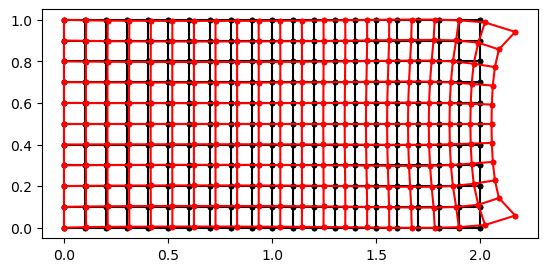

In [8]:
U_all = makeU(K) # 全体変位Uを導出
plot_result(U_all) # 結果表示